# Smith Investment Fund Alpha Competition 

December 2023

Authors: Neel Jay & Eckart Schneider


In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import json


In [2]:
from sif.siftools.backtesters import full_backtesters as fb
from sif.sifinsights.alpha_search import apply_metric_func
from sif.siftools import operators as op, metrics
from sif.sifinfra import sif_utils as su
from sif.siftools.abstractalpha import AbstractAlpha
import matplotlib.pyplot as plt
import datetime
plt.rcParams['figure.figsize'] = (15, 9)

## Alpha Definitions

First we look at simple optimization for sharpe ratio using contraints

In [3]:
class SROptimization(AbstractAlpha):
    def __init__(self):
        self.name = 'sr_optimization'
        self.lookback = 252
        self.factor_list = ['close']
        self.universe_size = 10
    
    def ret(r,w):
        return r.dot(w)
    # Risk level - or volatility
    def vol(w,covar):
        return np.sqrt(np.dot(w,np.dot(w,covar)))
    def sharpe (ret,vol):
        return ret/vol
    
    def generate_day(self, day, data):
        prices = pd.DataFrame(data['close'])
        percent_change = prices.pct_change() #df2
        df=percent_change.iloc[1:len(percent_change.index),:]

        r = np.mean(percent_change,axis=0)*self.lookback
        covar = percent_change.cov()

        from scipy.optimize import Bounds
        bounds = Bounds(0, 1)

        # The second boundary is the sum of weights.
        from scipy.optimize import LinearConstraint
        linear_constraint = LinearConstraint(np.ones((percent_change.shape[1],), dtype=int),1,1)
        
        # Find a portfolio with the minimum risk.
        from scipy.optimize import minimize
        #Create x0, the first guess at the values of each stock's weight.
        weights = np.ones(percent_change.shape[1])
        x0 = weights/np.sum(weights)

        #Define 1/Sharpe_ratio
        fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
        res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

        #These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
        w_sharpe = res_sharpe.x

        return w_sharpe

Now we utilize stock price over earnings to filter our portfolio. We find the 10 holdings with the lowest P/E, and run Sharpe Ratio optimization on these to get our final weights. We decide to use a default of 252 days lookback and 500 universe size (top stocks).

In [4]:
class PriceEarnings(AbstractAlpha):
    def __init__(self):
        self.name = 'price_earnings'
        self.lookback = 252
        self.factor_list = ['close', 'pe1']
        self.universe_size = 500
    
    def ret(r,w):
        return r.dot(w)
    # Risk level - or volatility
    def vol(w,covar):
        return np.sqrt(np.dot(w,np.dot(w,covar)))
    def sharpe (ret,vol):
        return ret/vol
    
    def generate_day(self, day, data):
        # print(day)
        pe = data['pe1'][day]
        
        z = zip(pe, list(range(len(pe))))
        z = sorted(z, key = lambda x: x[0])
        smallest_ten = list(map(lambda x: x[1], z[:10]))
        # print(smallest_ten)
        prices = pd.DataFrame(data['close']).iloc[:, smallest_ten]
        # print(prices)
        percent_change = prices.pct_change() #df2
        # df=percent_change.iloc[1:len(percent_change.index),:]

        r = np.mean(percent_change,axis=0)*self.lookback
        covar = percent_change.cov()

        from scipy.optimize import Bounds
        bounds = Bounds(0, 1)

        # The second boundary is the sum of weights.
        from scipy.optimize import LinearConstraint
        linear_constraint = LinearConstraint(np.ones((percent_change.shape[1],), dtype=int),1,1)
        
        # Find a portfolio with the minimum risk.
        from scipy.optimize import minimize
        #Create x0, the first guess at the values of each stock's weight.
        weights = np.ones(percent_change.shape[1])
        x0 = weights/np.sum(weights)

        #Define 1/Sharpe_ratio
        fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
        res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

        #These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
        w_sharpe = res_sharpe.x
        weight = np.zeros(self.universe_size)
        for i,x in enumerate(w_sharpe):
            weight[smallest_ten[i]] = x
        # print(weight)
        return weight
        


In [20]:
class RSI_CCI(AbstractAlpha):
    def __init__(self):
        self.name = 'rsi_cci'
        self.lookback = 252
        self.universe_size = 500
        self.factor_list = ['high', 'low', 'close']

    def generate_day(self, day, data):
        rsi_window = 14
        delta = np.diff(data['close'])
        up, down = np.clip(delta, a_min=0, a_max=None), abs(np.clip(delta, a_min=None, a_max=0))

        up, down = pd.DataFrame(up), pd.DataFrame(down)
        roll_up = up.ewm(span=rsi_window, adjust=False).mean()
        roll_down = down.ewm(span=rsi_window, adjust=False).mean()


        rs = roll_up/roll_down
                print(rs)

        rsi = 100.0-(100.0/(1.0+rs))

        rsi_day = rsi[day]

        print(rsi_day)
        
        holdings = np.array(rsi_day<30, dtype=np.int8)

        return op.weight(holdings)

ROE+ROA approach found in example code for testing.

In [6]:
class RoeRoaCombined(AbstractAlpha):
    def __init__(self):
        self.name = 'roe_roa_combined'
        self.lookback = 252
        self.universe_size = 500
        self.factor_list = ['netinc', 'assets', 'equity', 'sector']

    def generate_day(self, day, data):
        roe = data['netinc'] / data['equity']
        roa = data['netinc'] / data['assets']
        
        roe_change = op.group_zscore((roe[day] / roe[day - self.lookback]) - 1, data['sector'])
        roe_raw = op.group_zscore(roe[day], data['sector'])
        roe_factor = op.group_zscore(roe_change + roe_raw, data['sector'])
        
        roa_change = op.group_zscore((roa[day] / roa[day - self.lookback]) - 1, data['sector'])
        roa_raw = op.group_zscore(roa[day], data['sector'])
        roa_factor = op.group_zscore(roa_change + roa_raw, data['sector'])
        
        return op.weight(roe_factor + roa_factor)

## Backtesting

In [7]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2015, 12, 31)

In [8]:
rsi_backtester = fb.FullMultipleBacktester(
    start_date,
    end_date,
    'Q',
    252,
    universe_size=500,
    factors=['close', 'high', 'low']
)
rsi_backtester.save_local('rsi_backtester.npy')

/mnt/c/Users/neelj/Documents/CS/SIF/sif/sif/siftools/backtesters/abstractbacktester.py:94: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_dates = pd.Series(
/mnt/c/Users/neelj/Documents/CS/SIF/sif/sif/sifinfra/sif_utils.py:321: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execute_query(query, params=query_params)
/mnt/c/Users/neelj/Documents/CS/SIF/sif/sif/sifinfra/sif_utils.py:253: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execut

0

In [ ]:
pe_backtester = fb.FullMultipleBacktester(
    start_date,
    end_date,
    'Q',
    252,
    universe_size=500,
    factors=['close', 'pe1']
)
pe_backtester.save_local('pe_backtester.npy')

In [21]:
alphas = [RSI_CCI()]
returns, holdings = rsi_backtester.backtest(alphas, processes=None)

rsi_cci:   0%|          | 0/1 [00:00<?, ?it/s]/mnt/c/Users/neelj/Documents/CS/SIF/sif/sif/siftools/backtesters/full_backtesters.py:362: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series(index=self.trading_days)
/mnt/c/Users/neelj/Documents/CS/SIF/sif/sif/siftools/operators.py:95: RuntimeWarning: invalid value encountered in true_divide
  temp = temp / np.nansum(np.abs(temp))
rsi_cci:   0%|          | 0/1 [00:00<?, ?it/s]


0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
248    0.0
249    0.0
250    0.0
251    0.0
252    0.0
Name: 252, Length: 253, dtype: float64


ValueError: operands could not be broadcast together with shapes (500,) (253,) 

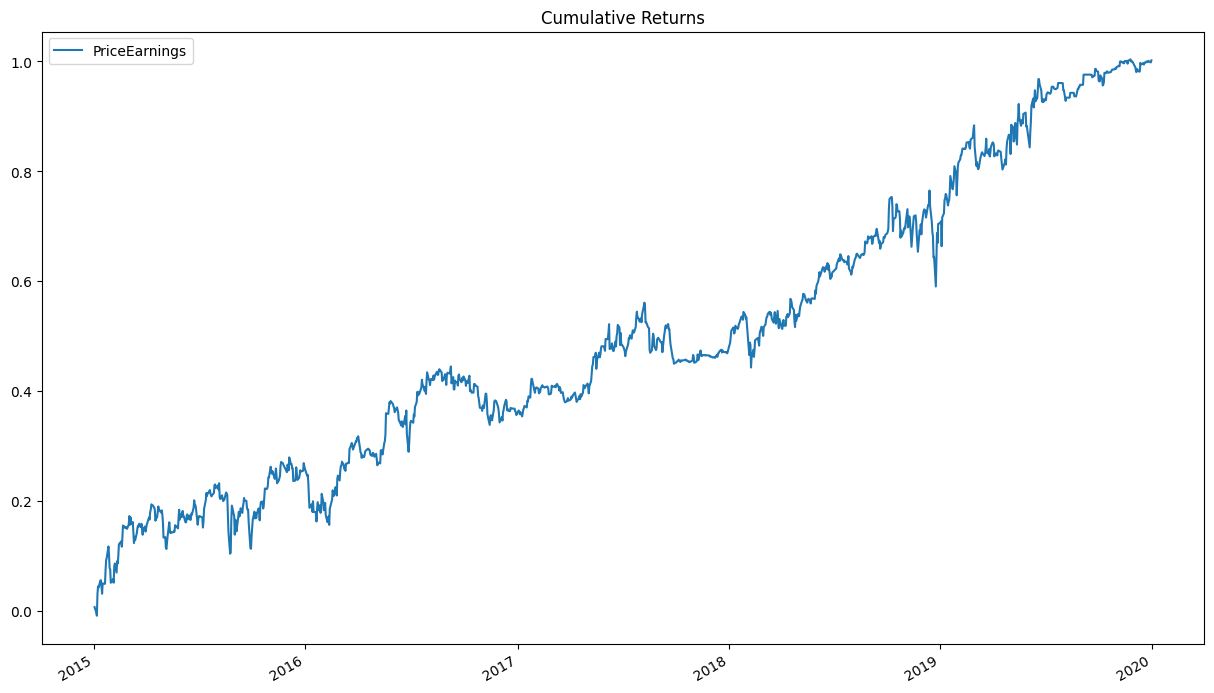

In [83]:
returns.cumsum().plot()
plt.legend(labels=['PriceEarnings'])
plt.title('Cumulative Returns')
plt.show()